## MODELOS ARIMA & LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos las librerias necesarias

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Importamos la data de Demanda de gas en sector eléctrico como un CSV

Se lee la data "original" de Demanda en sector eléctrico

In [49]:
demanda_electrico_original = pd.read_csv('Demanda_electrico_2023.csv',index_col='Date',parse_dates=True)
demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.585
2005-02-01,1895.325
2005-03-01,1765.856
2005-04-01,1642.696
2005-05-01,1895.540
...,...
2023-05-01,4376.446
2023-06-01,4863.337
2023-07-01,3924.540


Se grafica la data "original" de Demanda en sector eléctrico

Text(0, 0.5, 'Demanda [MMpcd]')

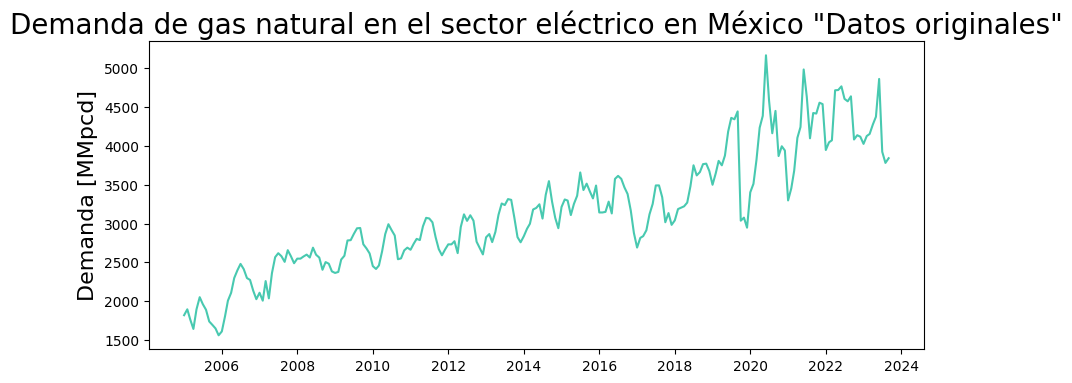

In [50]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

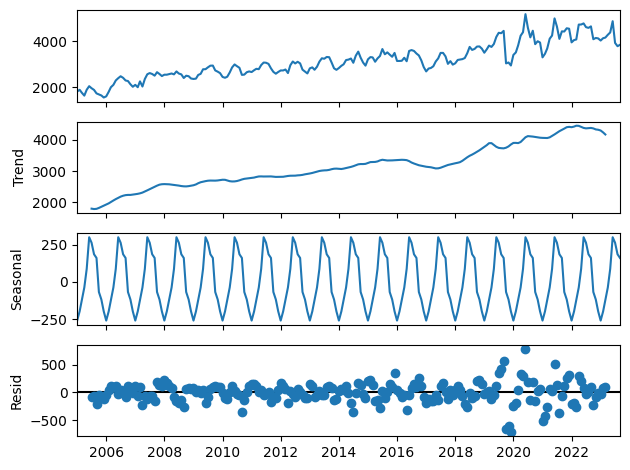

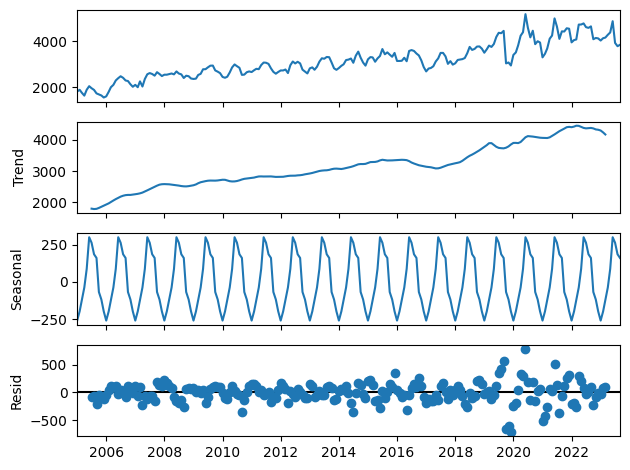

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_original_seasonal_decomposition = seasonal_decompose(demanda_electrico_original)
demanda_electrico_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector eléctrico en data de train y test

In [52]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.585
2005-02-01,1895.325
2005-03-01,1765.856
2005-04-01,1642.696
2005-05-01,1895.540
...,...
2022-05-01,4720.539
2022-06-01,4767.978
2022-07-01,4606.880


Se grafica la distribución de los datos "originales" de train de Demanda en sector eléctrico

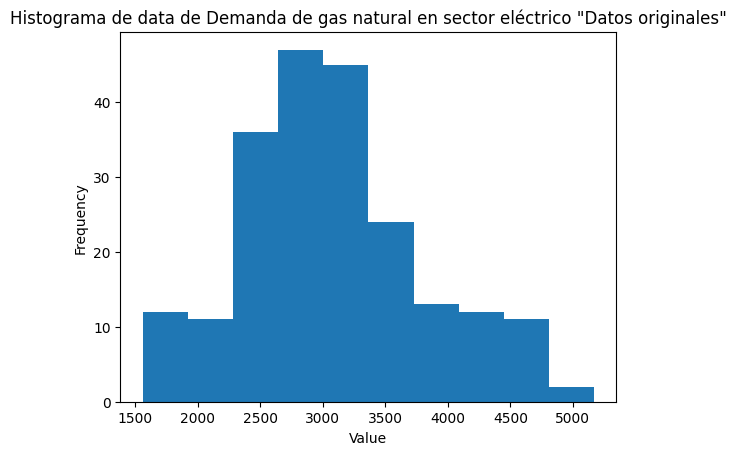

In [53]:
# Generate the histogram
plt.hist(demanda_electrico_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

In [54]:
demanda_electrico_original_train_data.describe()

,Demanded_Gas
count,213.000000
mean,3082.221465
std,735.206938
min,1560.985000
25%,2598.570000
50%,3016.100000
75%,3490.297000
max,5168.267000


In [55]:
mean_demanda_electrico_original_train_data =  demanda_electrico_original_train_data.describe().values[1]
mean_demanda_electrico_original_train_data

array([3082.22146479])

In [56]:
st_demanda_electrico_original_train_data =  demanda_electrico_original_train_data.describe().values[2]
st_demanda_electrico_original_train_data

array([735.20693781])

In [57]:
st_demanda_electrico_original_train_data / mean_demanda_electrico_original_train_data

array([0.23853151])

In [58]:
mean_demanda_electrico_original_train_data / st_demanda_electrico_original_train_data

array([4.19231825])

Se lleva a cabo una prueba de normalidad a los datos "originales escalados" de train de Demanda en sector eléctrico

In [59]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_original_train_data

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 7.2481733141026705
p-value: 0.026673448220157145


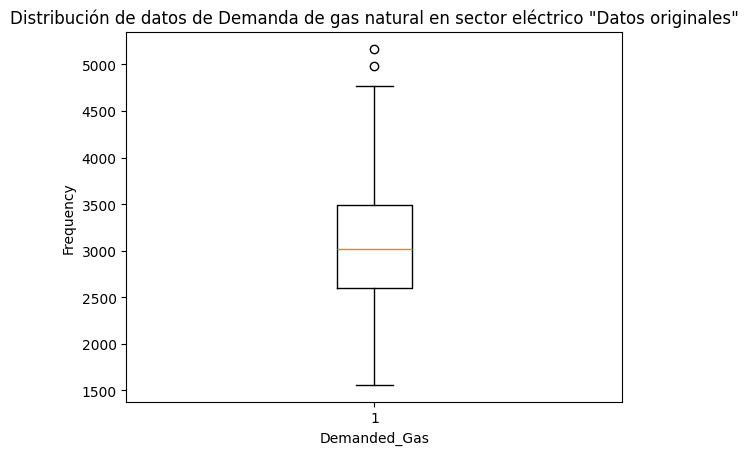

In [60]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [61]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [62]:
demanda_electrico_original_train_data["Demanded_Gas"]

Date
2005-01-01    1819.585
2005-02-01    1895.325
2005-03-01    1765.856
2005-04-01    1642.696
2005-05-01    1895.540
                ...   
2022-05-01    4720.539
2022-06-01    4767.978
2022-07-01    4606.880
2022-08-01    4575.179
2022-09-01    4639.519
Name: Demanded_Gas, Length: 213, dtype: float64

In [63]:
n_input = 24

data = demanda_electrico_original_train_data["Demanded_Gas"]
targets = data 


demanda_electrico_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [64]:
demanda_electrico_original_train_generator[176]

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[4445.273, 3037.441, 3076.623, 2947.094, 3402.472, 3512.452,
         3819.296, 4235.255, 4387.91 , 5168.267, 4581.994, 4163.774,
         4451.613, 3869.766, 3996.138, 3941.119, 3298.428, 3454.211,
         3681.295, 4104.817, 4243.934, 4985.526, 4631.854, 4098.808]]),
 array([4424.394]))

In [65]:
print("Total number of samples in the original training data = ", len(demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_original_train_generator))


Total number of samples in the original training data =  213
Total number of samples in the demanda_electrico_scaled_train_generator =  189


### Se define y entrena la red neuronal FFNN  para el caso de la data original de Demanda en el sector eléctrico

In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [67]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal FFNN con capas densas y funcion de activación tipo RELU.

In [68]:
n_input = n_input
n_features = 1

# define model
model_FF_electrico_sin_tratamiento = Sequential()
model_FF_electrico_sin_tratamiento.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_electrico_sin_tratamiento.add(Dense(32, activation='relu'))
model_FF_electrico_sin_tratamiento.add(Dense(1))
model_FF_electrico_sin_tratamiento.compile(optimizer='Adam', loss='mse')

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
model_FF_electrico_sin_tratamiento.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 24, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model_FF_electrico_sin_tratamiento.fit(demanda_electrico_original_train_generator, epochs=12)

Epoch 1/12


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 2465710.7500
Epoch 2/12
  1/189 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 579269.9375

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 182614.8125
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 166029.7031
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 216245.0000
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 209744.3594
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 164820.8906
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 181714.8594
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 188021.5312
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 200418.7969
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 180780.1562
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 172621.8750
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 202654.9219


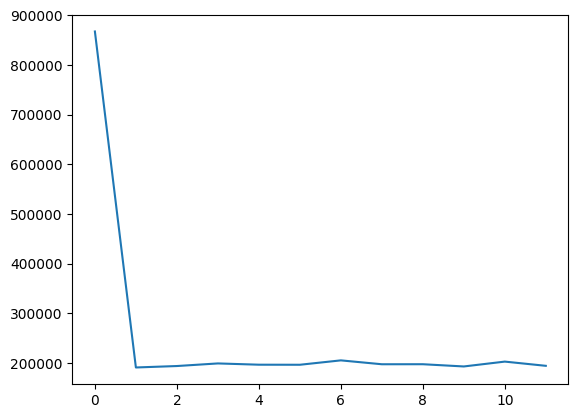

In [71]:
loss_per_epoch_model_FF = model_FF_electrico_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [72]:
n_input = n_input
n_features = n_features

In [73]:
test_predictions_model_FF_electrico_sin_pretratamiento = []

first_eval_batch = demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_FF_electrico_sin_tratamiento.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_electrico_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [74]:
test_predictions_model_FF_electrico_sin_pretratamiento

[5045.993,
 5487.91,
 5968.3594,
 6490.703,
 7058.5923,
 7675.998,
 8347.238,
 9077.008,
 9870.41,
 10732.994,
 11670.792,
 12690.362]

Text(0, 0.5, 'Demanda [MMpcd]')

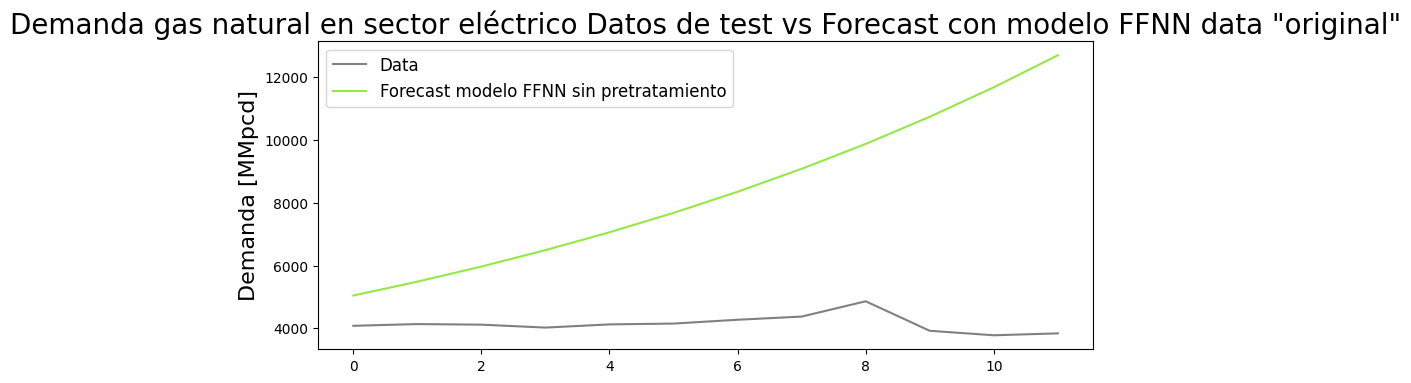

In [75]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_FF_electrico_sin_pretratamiento, color='#94E844')
plt.legend(('Data', 'Forecast modelo FFNN sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo FFNN data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector eléctrico

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [76]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [77]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_electrico = Sequential()
model_LSTM_electrico.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico.add(Dense(1))
model_LSTM_electrico.compile(optimizer='adam', loss='mse')

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [78]:
model_LSTM_electrico.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo LSTM

In [79]:
model_LSTM_electrico.fit(demanda_electrico_original_train_generator, epochs=12)


Epoch 1/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4902643.5000
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 398955.0312
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 752968.8750
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 859630.2500
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 390983.6250
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 882435.4375
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 144958.1250
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 138033.2500
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 111122.6562
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 92168.2422
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 144788.0156
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 123989.1328


Se grafica la perdida por epoch

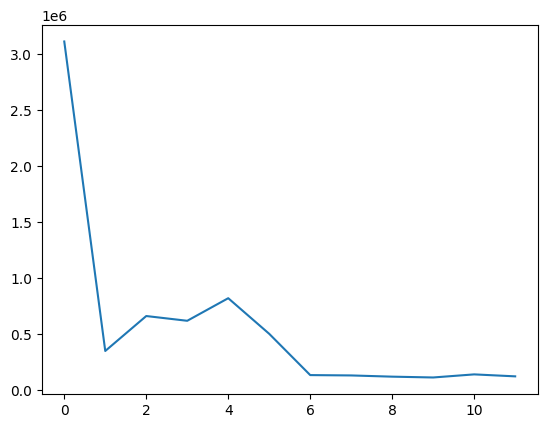

In [80]:
loss_per_epoch_model_FF = model_LSTM_electrico.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

In [81]:
n_input = n_input
n_features = n_features

In [82]:
first_eval_batch = demanda_electrico_original_train_data[-n_input:]
first_eval_batch

,Demanded_Gas
Date,
2020-10-01,3869.766
2020-11-01,3996.138
2020-12-01,3941.119
2021-01-01,3298.428
2021-02-01,3454.211
2021-03-01,3681.295
2021-04-01,4104.817
2021-05-01,4243.934
2021-06-01,4985.526


In [83]:
test_predictions_model_LSTM_electrico = []

first_eval_batch = demanda_electrico_original_train_data[-n_input:]["Demanded_Gas"].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [84]:
test_predictions_model_LSTM_electrico

[array([4256.7397], dtype=float32),
 array([4127.4736], dtype=float32),
 array([4387.146], dtype=float32),
 array([4375.5503], dtype=float32),
 array([4359.5522], dtype=float32),
 array([4531.446], dtype=float32),
 array([4706.194], dtype=float32),
 array([4832.421], dtype=float32),
 array([4750.9497], dtype=float32),
 array([4633.4624], dtype=float32),
 array([4725.3574], dtype=float32),
 array([4718.5386], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM con la data de entrenamiento 

Text(0, 0.5, 'Demanda [MMpcd]')

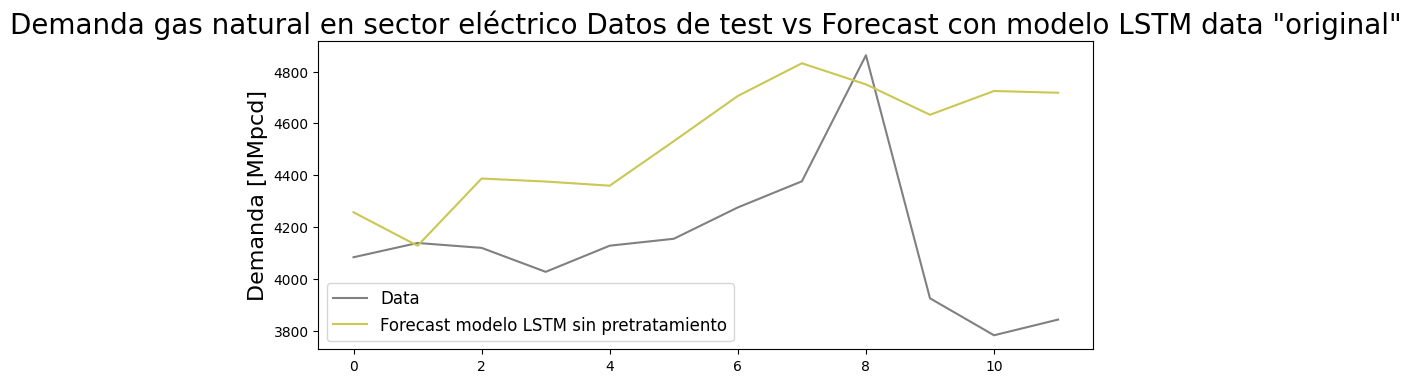

In [85]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo LSTM sin la data pretratada

In [86]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_electrico_original = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico)
RMSE_predictions_model_LSTM_electrico_original = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico))

print('MAPE:', MAPE_predictions_model_LSTM_electrico_original)
print('RMSE:', RMSE_predictions_model_LSTM_electrico_original)

MAPE: 0.10249624506660428
RMSE: 498.88023347864424


#### Proceso para decidir el modelo ARIMA a aplicar en el caso de (SIN pretratamiento de atípicos)

Se verifica la estacionariedad de la data original con ayuda de la prueba de  Dickey-Fulley 

In [87]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_electrico_original_sin_diferenciar = adfuller(demanda_electrico_original)


adf_test_electrico_original_sin_diferenciar

(-1.6819036947454782,
 0.4404595256470362,
 12,
 212,
 {'1%': -3.4615775784078466,
  '5%': -2.875271898983725,
  '10%': -2.5740891037735847},
 2818.0554123166203)

In [88]:
print(f"The ADF statistic value f is: {adf_test_electrico_original_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_electrico_original_sin_diferenciar[1]}")

if adf_test_electrico_original_sin_diferenciar[0] < adf_test_electrico_original_sin_diferenciar[4]['5%']:
        print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -1.6819036947454782
The ADF p value p is: 0.4404595256470362
Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad


Se procede a hacer la primer diferencia para lograr estacionariedad 

In [89]:
demanda_electrico_original_diff1 = demanda_electrico_original.diff()
demanda_electrico_original_diff1

,Demanded_Gas
Date,
2005-01-01,NaN
2005-02-01,75.740
2005-03-01,-129.469
2005-04-01,-123.160
2005-05-01,252.844
...,...
2023-05-01,100.895
2023-06-01,486.891
2023-07-01,-938.797


Se verifica la estacionariedad de la data original CON UNA DIFERENCIA con ayuda de la prueba de  Dickey-Fulley 

In [90]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_electrico_original_con_diferencia = adfuller(demanda_electrico_original_diff1.dropna())


adf_test_electrico_original_con_diferencia

(-6.369926808590504,
 2.358822312367949e-08,
 11,
 212,
 {'1%': -3.4615775784078466,
  '5%': -2.875271898983725,
  '10%': -2.5740891037735847},
 2805.4548673477075)

In [91]:
print(f"The ADF statistic value f is: {adf_test_electrico_original_con_diferencia[0]}")

print(f"The ADF p value p is: {adf_test_electrico_original_con_diferencia[1]}")

if adf_test_electrico_original_con_diferencia[0] < adf_test_electrico_original_con_diferencia[4]['5%']:
        print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -6.369926808590504
The ADF p value p is: 2.358822312367949e-08
Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad


Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar 

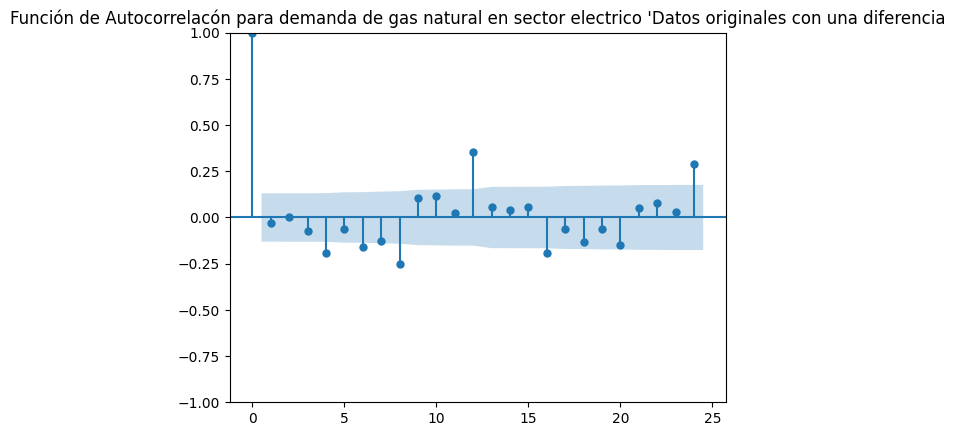

In [92]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_electrico_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector electrico 'Datos originales con una diferencia")

# Show the plot
plt.show()

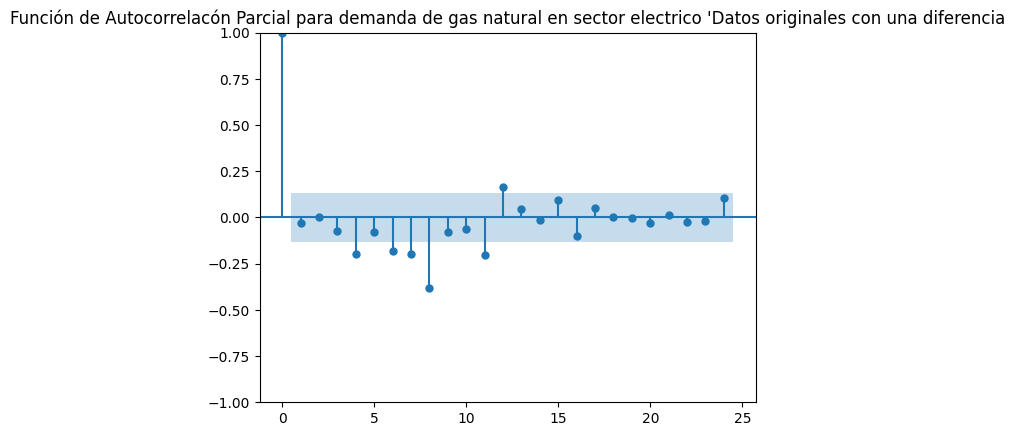

In [93]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_electrico_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector electrico 'Datos originales con una diferencia")

# Show the plot
plt.show()

### Se define y entrena modelo ARIMA para el caso de la data original de Demanda en el sector eléctrico

In [94]:
##Create the model
model_ARIMA_electrico_original = ARIMA (demanda_electrico_original_train_data, order=(4,1,4))

##Fit the model
start = time()
model_ARIMA_electrico_original_fit = model_ARIMA_electrico_original.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_original_fit.summary())

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitting time 0.5842199325561523
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1417.649
Date:                Fri, 03 May 2024   AIC                           2853.298
Time:                        11:57:39   BIC                           2883.507
Sample:                    01-01-2005   HQIC                          2865.508
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9054      0.061     14.739      0.000       0.785       1.026
ar.L2         -0.4439      0.067     -6.645      0.000      -0.575      -0.313
ar.L3         

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [95]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

##get the predictors and residuals 
predictions_model_ARIMA_electrico_original = model_ARIMA_electrico_original_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
predictions_model_ARIMA_electrico_original


2022-10-01    4618.898396
2022-11-01    4436.539092
2022-12-01    4477.569808
2023-01-01    4566.784044
2023-02-01    4483.747954
2023-03-01    4552.110805
2023-04-01    4697.207672
2023-05-01    4652.631097
2023-06-01    4675.435759
2023-07-01    4789.929717
2023-08-01    4727.132533
2023-09-01    4675.581408
Freq: MS, Name: predicted_mean, dtype: float64

In [96]:
predictions_model_ARIMA_electrico_original.values

array([4618.89839639, 4436.53909167, 4477.56980764, 4566.78404444,
       4483.74795413, 4552.11080455, 4697.20767223, 4652.63109744,
       4675.43575865, 4789.92971652, 4727.13253331, 4675.58140808])

In [97]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_electrico_original = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_original.values)
RMSE_predictions_model__ARIMA_electrico_original= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_original.values))

print('MAPE:', MAPE_predictions_model_ARIMA_electrico_original)
print('RMSE:', RMSE_predictions_model__ARIMA_electrico_original)

MAPE: 0.12451366518998798
RMSE: 555.8534657578024


Text(0, 0.5, 'Demanda [MMpcd]')

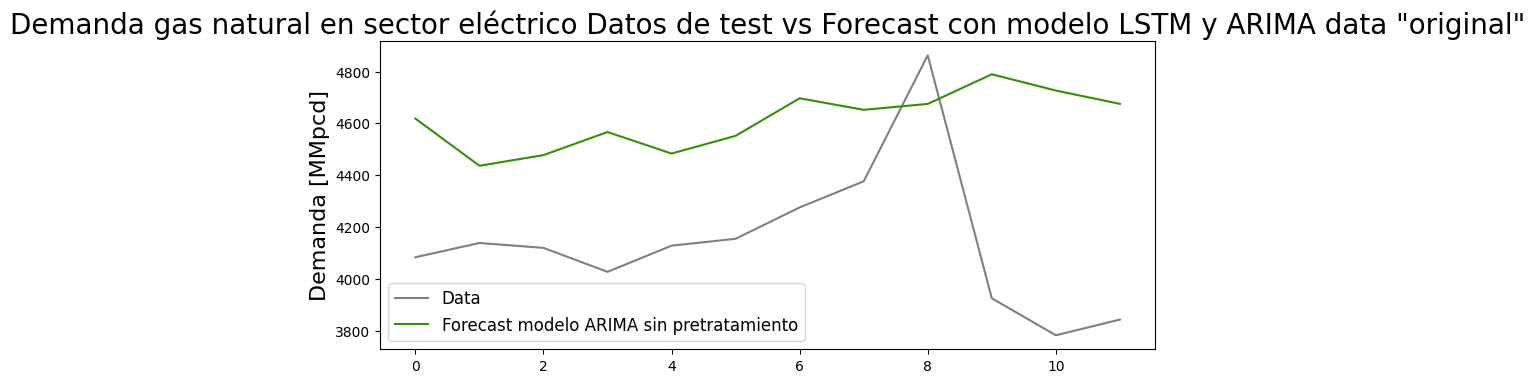

In [98]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Forecast modelo ARIMA sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM y ARIMA data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

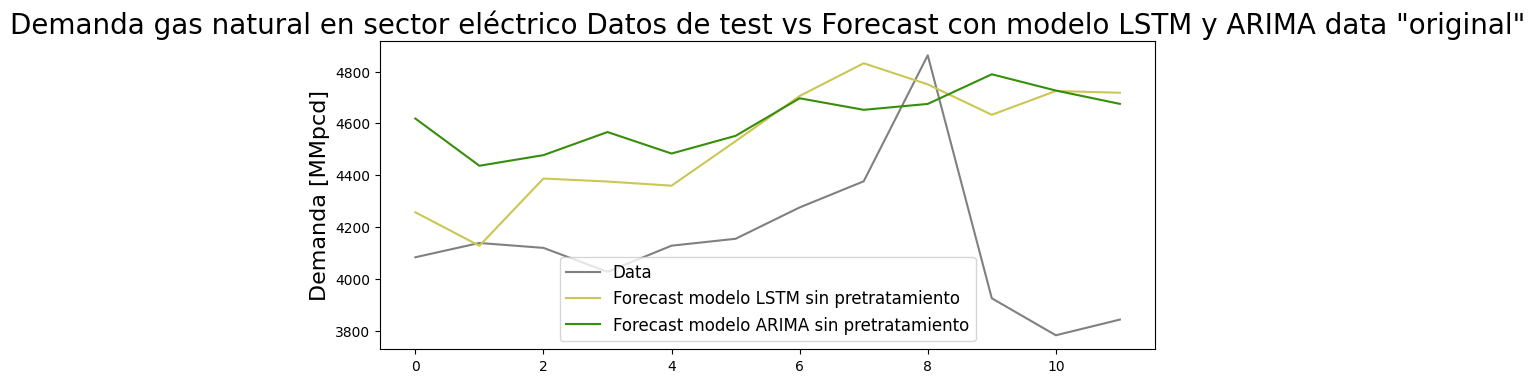

In [99]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento', 'Forecast modelo ARIMA sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM y ARIMA data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [100]:
outlier_threshold = 1.25

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [101]:
demanda_electrico_original_train_para_tratamiento =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,1819.585
2005-02-01,1895.325
2005-03-01,1765.856
2005-04-01,1642.696
2005-05-01,1895.540
...,...
2022-05-01,4720.539
2022-06-01,4767.978
2022-07-01,4606.880


In [102]:
demanda_electrico_train_pretratamiento_media = remove_replace_outliers_media(demanda_electrico_original_train_para_tratamiento['Demanded_Gas'])
demanda_electrico_train_pretratamiento_media

Date
2005-01-01    1819.585000
2005-02-01    1895.325000
2005-03-01    1765.856000
2005-04-01    1642.696000
2005-05-01    1895.540000
                 ...     
2022-05-01    3015.977122
2022-06-01    3015.977122
2022-07-01    3015.977122
2022-08-01    4575.179000
2022-09-01    3015.977122
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

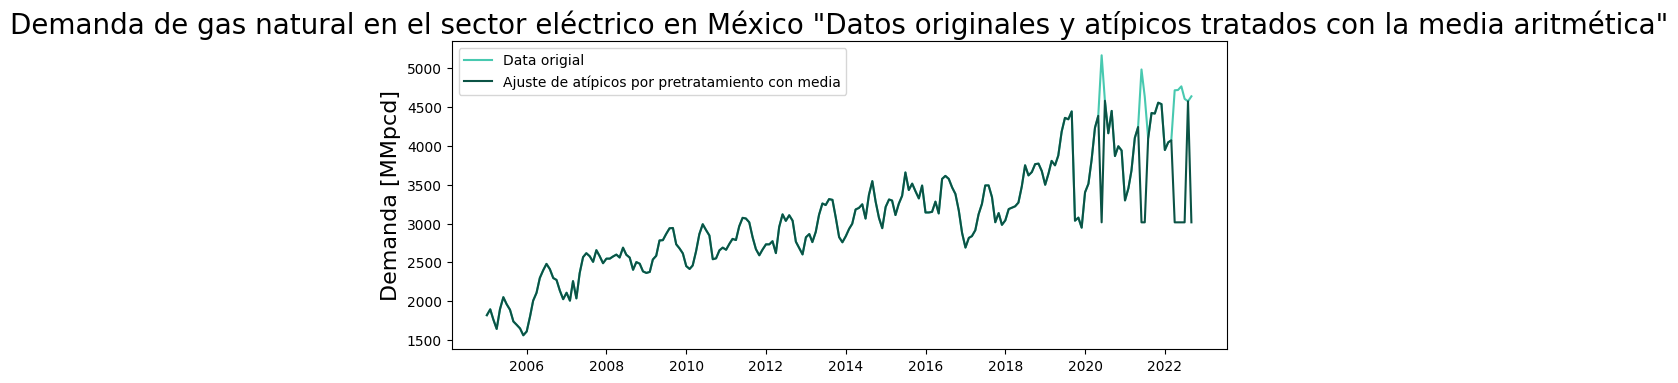

In [103]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales y atípicos tratados con la media aritmética"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

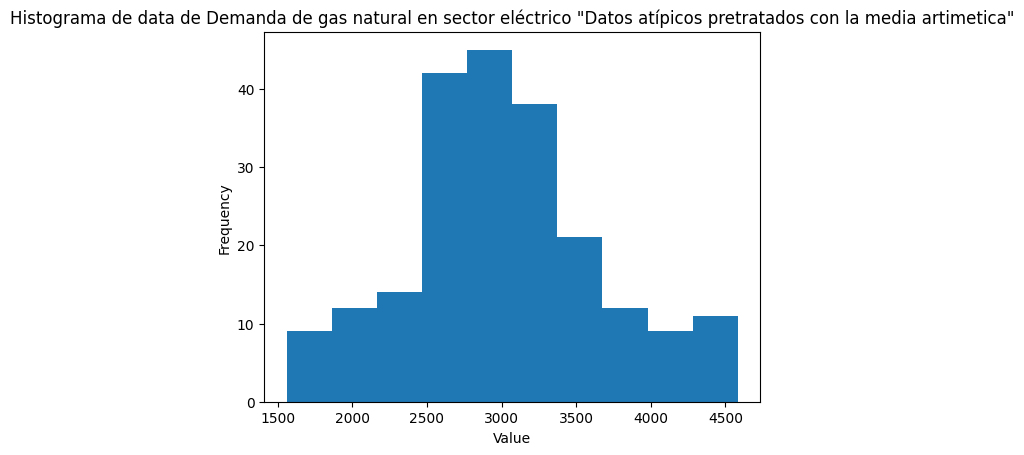

In [104]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

In [105]:
demanda_electrico_train_pretratamiento_media.describe()

count     213.000000
mean     3015.977122
std       652.889017
min      1560.985000
25%      2598.570000
50%      3015.977122
75%      3370.221000
max      4581.994000
Name: Demanded_Gas, dtype: float64

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [106]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 2.4388113473308106
p-value: 0.2954056821384746


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

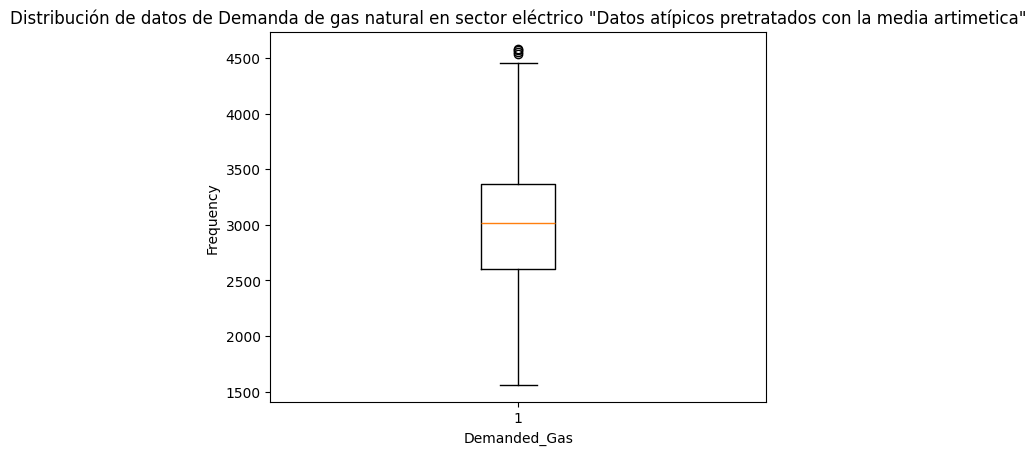

In [107]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [108]:
n_input = n_input


data = demanda_electrico_train_pretratamiento_media
targets = data 

demanda_electrico_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [109]:
demanda_electrico_train_generator_pretratamiento_media[0]

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[1819.585, 1895.325, 1765.856, 1642.696, 1895.54 , 2051.723,
         1962.054, 1889.656, 1739.1  , 1695.917, 1648.948, 1560.985,
         1610.451, 1806.332, 2006.884, 2108.311, 2298.896, 2398.883,
         2480.623, 2413.083, 2298.488, 2273.91 , 2134.41 , 2025.984]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [110]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_media)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_media))

Total number of samples in the original training data =  213
Total number of samples in the demanda_electrico_scaled_train_generator =  189


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [180]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)



In [181]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_electrico_pretratamiento_media = Sequential()
model_LSTM_electrico_pretratamiento_media.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretratamiento_media.add(Dense(1))
model_LSTM_electrico_pretratamiento_media.compile(optimizer='adam', loss='mse')

In [113]:
model_LSTM_electrico_pretratamiento_media.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [182]:
model_LSTM_electrico_pretratamiento_media.fit(demanda_electrico_train_generator_pretratamiento_media, epochs=12)

Epoch 1/12


c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7807974.0000
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 869651.6250
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 266832.3125
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 272915.3750
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 113713.6562
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 136467.6562
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 129648.2500
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 135383.8594
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 133708.5938
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 140294.1562
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 125089.3516
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 148051.5469


Se grafica la perdida por epoch 

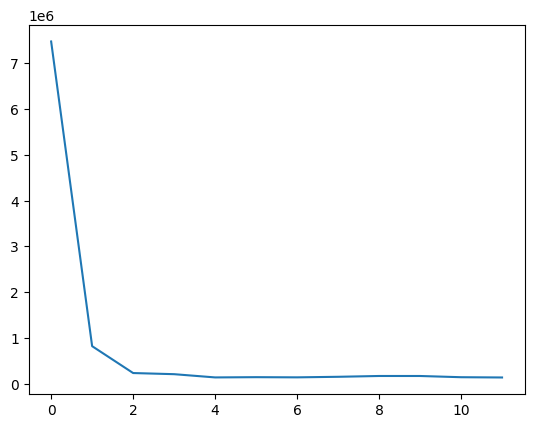

In [183]:
loss_per_epoch = model_LSTM_electrico_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [116]:
demanda_electrico_train_batch_pretratamiento_media = demanda_electrico_train_pretratamiento_media[-n_input:]


demanda_electrico_train_batch_pretratamiento_media

Date
2020-10-01    3869.766000
2020-11-01    3996.138000
2020-12-01    3941.119000
2021-01-01    3298.428000
2021-02-01    3454.211000
2021-03-01    3681.295000
2021-04-01    4104.817000
2021-05-01    4243.934000
2021-06-01    3015.977122
2021-07-01    3015.977122
2021-08-01    4098.808000
2021-09-01    4424.394000
2021-10-01    4417.514000
2021-11-01    4557.360000
2021-12-01    4538.887000
2022-01-01    3947.786000
2022-02-01    4046.826000
2022-03-01    4072.984000
2022-04-01    3015.977122
2022-05-01    3015.977122
2022-06-01    3015.977122
2022-07-01    3015.977122
2022-08-01    4575.179000
2022-09-01    3015.977122
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [117]:
demanda_electrico_train_batch_pretratamiento_media_reshaped = demanda_electrico_train_batch_pretratamiento_media.values.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_media_reshaped

array([[[3869.766     ],
        [3996.138     ],
        [3941.119     ],
        [3298.428     ],
        [3454.211     ],
        [3681.295     ],
        [4104.817     ],
        [4243.934     ],
        [3015.97712195],
        [3015.97712195],
        [4098.808     ],
        [4424.394     ],
        [4417.514     ],
        [4557.36      ],
        [4538.887     ],
        [3947.786     ],
        [4046.826     ],
        [4072.984     ],
        [3015.97712195],
        [3015.97712195],
        [3015.97712195],
        [3015.97712195],
        [4575.179     ],
        [3015.97712195]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [118]:
model_LSTM_electrico_pretratamiento_media.predict(demanda_electrico_train_batch_pretratamiento_media_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


array([[5381.229]], dtype=float32)

Y se compara el valor de forecast del modelo LSTM + pretratamiento media con los datos de test de la demanda de gas natural en sector eléctrico

In [119]:
demanda_electrico_original_test_data

,Demanded_Gas
Date,
2022-10-01,4083.041
2022-11-01,4138.196
2022-12-01,4119.271
2023-01-01,4026.742
2023-02-01,4127.763
2023-03-01,4154.443
2023-04-01,4275.551
2023-05-01,4376.446
2023-06-01,4863.337


Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [120]:
n_input = n_input
n_features = n_features

In [121]:
demanda_electrico_train_pretratamiento_media[-n_input:]

Date
2020-10-01    3869.766000
2020-11-01    3996.138000
2020-12-01    3941.119000
2021-01-01    3298.428000
2021-02-01    3454.211000
2021-03-01    3681.295000
2021-04-01    4104.817000
2021-05-01    4243.934000
2021-06-01    3015.977122
2021-07-01    3015.977122
2021-08-01    4098.808000
2021-09-01    4424.394000
2021-10-01    4417.514000
2021-11-01    4557.360000
2021-12-01    4538.887000
2022-01-01    3947.786000
2022-02-01    4046.826000
2022-03-01    4072.984000
2022-04-01    3015.977122
2022-05-01    3015.977122
2022-06-01    3015.977122
2022-07-01    3015.977122
2022-08-01    4575.179000
2022-09-01    3015.977122
Name: Demanded_Gas, dtype: float64

In [184]:
test_predictions_model_LSTM_electrico_pretratamiento_media  = []

first_eval_batch = demanda_electrico_train_pretratamiento_media[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [185]:
test_predictions_model_LSTM_electrico_pretratamiento_media

[array([4589.414], dtype=float32),
 array([4228.955], dtype=float32),
 array([4303.821], dtype=float32),
 array([4231.7305], dtype=float32),
 array([4275.755], dtype=float32),
 array([4226.918], dtype=float32),
 array([4136.0264], dtype=float32),
 array([4230.14], dtype=float32),
 array([3911.4875], dtype=float32),
 array([4075.1602], dtype=float32),
 array([4098.135], dtype=float32),
 array([3983.7046], dtype=float32)]

In [186]:
demanda_electrico_original_test_data['Demanded_Gas'].values

array([4083.041, 4138.196, 4119.271, 4026.742, 4127.763, 4154.443,
       4275.551, 4376.446, 4863.337, 3924.54 , 3781.63 , 3842.285])

Text(0, 0.5, 'Demanda [MMpcd]')

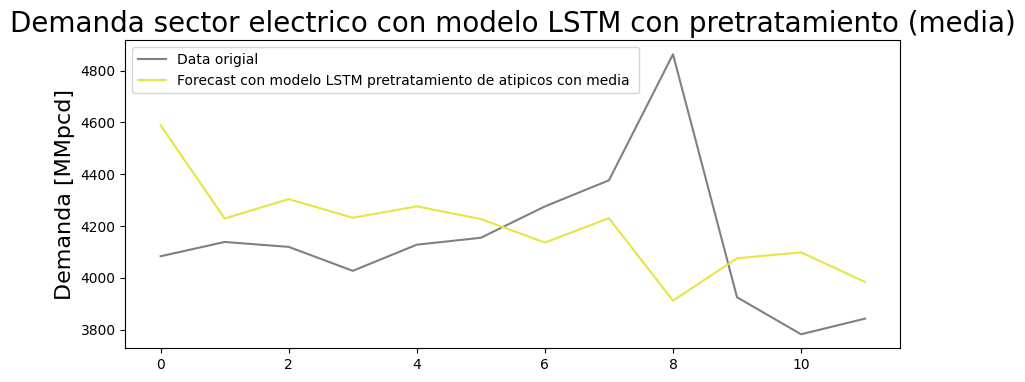

In [187]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media '))

plt.title('Demanda sector electrico con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [188]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media)

MAPE: 0.05963502617188434
RMSE: 348.52488116131684


Se muestra la comparación del forecast de demanda electrico con modelo LSTM entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

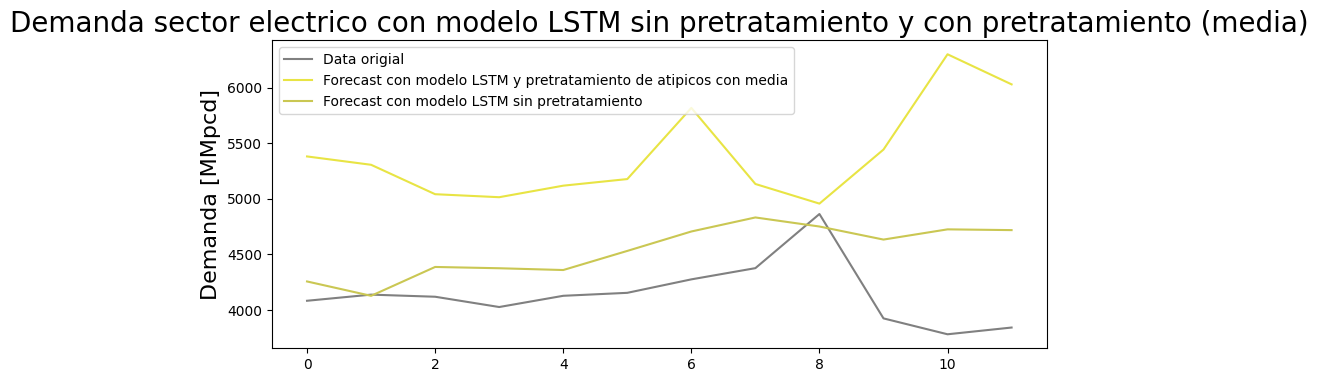

In [127]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

#### Proceso para decidir el modelo ARIMA a aplicar en el caso de (pretratamiento de atípicos por la media)

Se verifica la estacionariedad de la data (pretratamiento de atípicos por la media) con ayuda de la prueba de  Dickey-Fulley 

In [128]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_electrico_pretratamiento_media_sin_diferenciar = adfuller(demanda_electrico_train_pretratamiento_media)

adf_test_electrico_pretratamiento_media_sin_diferenciar

(-2.0697382419027353,
 0.2568557741484685,
 15,
 197,
 {'1%': -3.463987334463603,
  '5%': -2.8763259091636213,
  '10%': -2.5746515171738515},
 2789.9636446677932)

In [129]:
print(f"The ADF statistic value f is: {adf_test_electrico_pretratamiento_media_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_electrico_pretratamiento_media_sin_diferenciar[1]}")

if adf_test_electrico_pretratamiento_media_sin_diferenciar[0] < adf_test_electrico_pretratamiento_media_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -2.0697382419027353
The ADF p value p is: 0.2568557741484685
Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad


Se procede a hacer la primer diferencia para lograr estacionariedad

In [130]:
demanda_electrico_pretratamiento_media_diff1 = demanda_electrico_train_pretratamiento_media.diff()
demanda_electrico_pretratamiento_media_diff1

Date
2005-01-01            NaN
2005-02-01      75.740000
2005-03-01    -129.469000
2005-04-01    -123.160000
2005-05-01     252.844000
                 ...     
2022-05-01       0.000000
2022-06-01       0.000000
2022-07-01       0.000000
2022-08-01    1559.201878
2022-09-01   -1559.201878
Name: Demanded_Gas, Length: 213, dtype: float64

Se verifica la estacionariedad de la data DIFERENCIA1 (pretratamiento de atípicos por la media) con ayuda de la prueba de  Dickey-Fulley 

In [131]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_electrico_pretratamiento_media_diff1 = adfuller(demanda_electrico_pretratamiento_media_diff1.dropna())

adf_test_electrico_pretratamiento_media_diff1

(-5.013085719410747,
 2.0907090567190573e-05,
 14,
 197,
 {'1%': -3.463987334463603,
  '5%': -2.8763259091636213,
  '10%': -2.5746515171738515},
 2779.0029725762174)

In [132]:
print(f"The ADF statistic value f is: {adf_test_electrico_pretratamiento_media_diff1[0]}")

print(f"The ADF p value p is: {adf_test_electrico_pretratamiento_media_diff1[1]}")

if adf_test_electrico_pretratamiento_media_diff1[0] < adf_test_electrico_pretratamiento_media_diff1[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -5.013085719410747
The ADF p value p is: 2.0907090567190573e-05
Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad


Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar

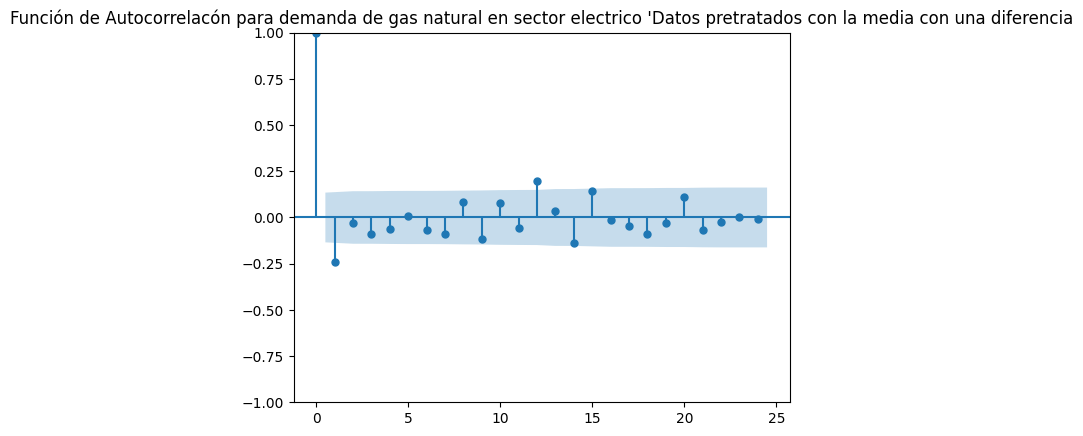

In [133]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_electrico_pretratamiento_media_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector electrico 'Datos pretratados con la media con una diferencia")

# Show the plot
plt.show()

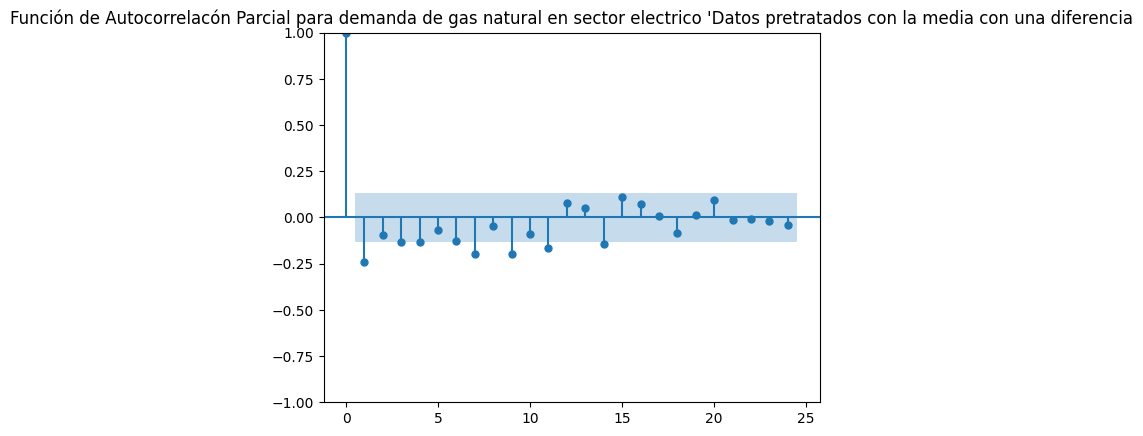

In [134]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_electrico_pretratamiento_media_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector electrico 'Datos pretratados con la media con una diferencia")

# Show the plot
plt.show()

Apliquemos un modelo ARIMA a nuestra data de Demanda de gas natural en sector eléctrico 'Datos atipicos con tratamiento media'

In [135]:
##Create the model
model_ARIMA_electrico_tratamiento_media = ARIMA (demanda_electrico_train_pretratamiento_media, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_electrico_tratamiento_media_fit = model_ARIMA_electrico_tratamiento_media.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_tratamiento_media_fit.summary())

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\s

Model fitting time 0.9439084529876709
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1498.603
Date:                Fri, 03 May 2024   AIC                           3011.206
Time:                        11:57:57   BIC                           3034.702
Sample:                    01-01-2005   HQIC                          3020.702
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2183      0.090      2.415      0.016       0.041       0.395
ar.L2         -0.7660      0.057    -13.379      0.000      -0.878      -0.654
ar.L3         

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [136]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

In [137]:
##get the predictors and residuals 
predictions_model_ARIMA_electrico_tratamiento_media = model_ARIMA_electrico_tratamiento_media_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
print(predictions_model_ARIMA_electrico_tratamiento_media)

2022-10-01    3287.438836
2022-11-01    3464.528562
2022-12-01    3547.248591
2023-01-01    3550.589527
2023-02-01    3566.846476
2023-03-01    3604.685212
2023-04-01    3601.981106
2023-05-01    3579.649924
2023-06-01    3593.702435
2023-07-01    3612.670066
2023-08-01    3596.099044
2023-09-01    3584.213332
Freq: MS, Name: predicted_mean, dtype: float64


In [138]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_electrico_tratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_media)
RMSE_predictions_model_ARIMA_electrico_tratamiento_media= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_media))

print('MAPE:', MAPE_predictions_model_ARIMA_electrico_tratamiento_media)
print('RMSE:', RMSE_predictions_model_ARIMA_electrico_tratamiento_media)

MAPE: 0.13994500811231925
RMSE: 655.5176263602883


Text(0, 0.5, 'Demanda [MMpcd]')

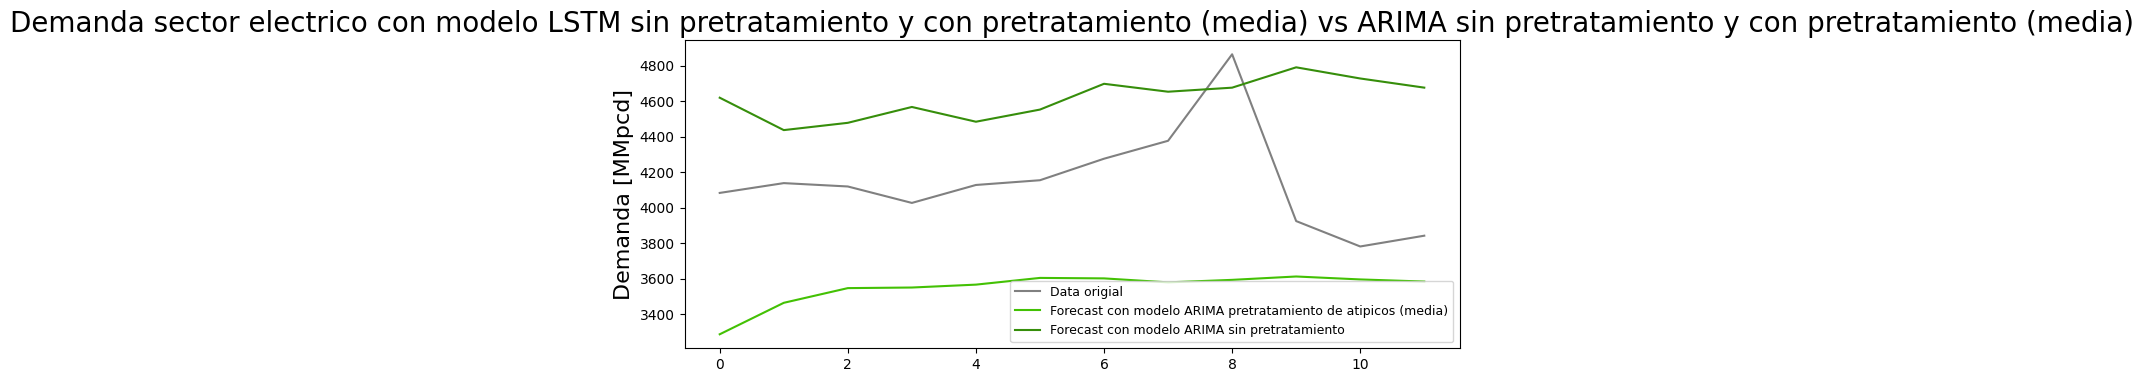

In [139]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(predictions_model_ARIMA_electrico_tratamiento_media.values,color='#43C104')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo ARIMA pretratamiento de atipicos (media)','Forecast con modelo ARIMA sin pretratamiento ' ), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media) vs ARIMA sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

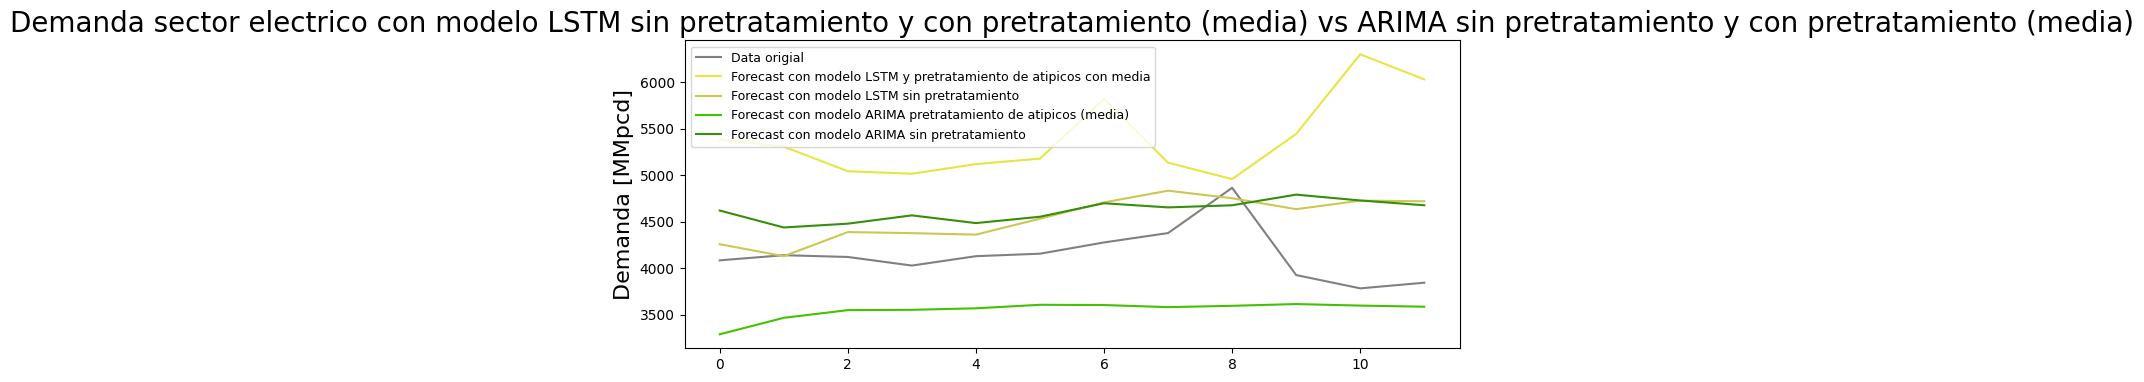

In [140]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(predictions_model_ARIMA_electrico_tratamiento_media.values,color='#43C104')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento de atipicos (media)','Forecast con modelo ARIMA sin pretratamiento ' ), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media) vs ARIMA sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [141]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [142]:
demanda_electrico_original_train_para_tratamiento2 =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,1819.585
2005-02-01,1895.325
2005-03-01,1765.856
2005-04-01,1642.696
2005-05-01,1895.540
...,...
2022-05-01,4720.539
2022-06-01,4767.978
2022-07-01,4606.880


In [143]:
demanda_electrico_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_electrico_original_train_para_tratamiento2['Demanded_Gas'])
demanda_electrico_train_pretratamiento_mediana

Date
2005-01-01    1819.585
2005-02-01    1895.325
2005-03-01    1765.856
2005-04-01    1642.696
2005-05-01    1895.540
                ...   
2022-05-01    2955.931
2022-06-01    2955.931
2022-07-01    2955.931
2022-08-01    2955.931
2022-09-01    2955.931
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

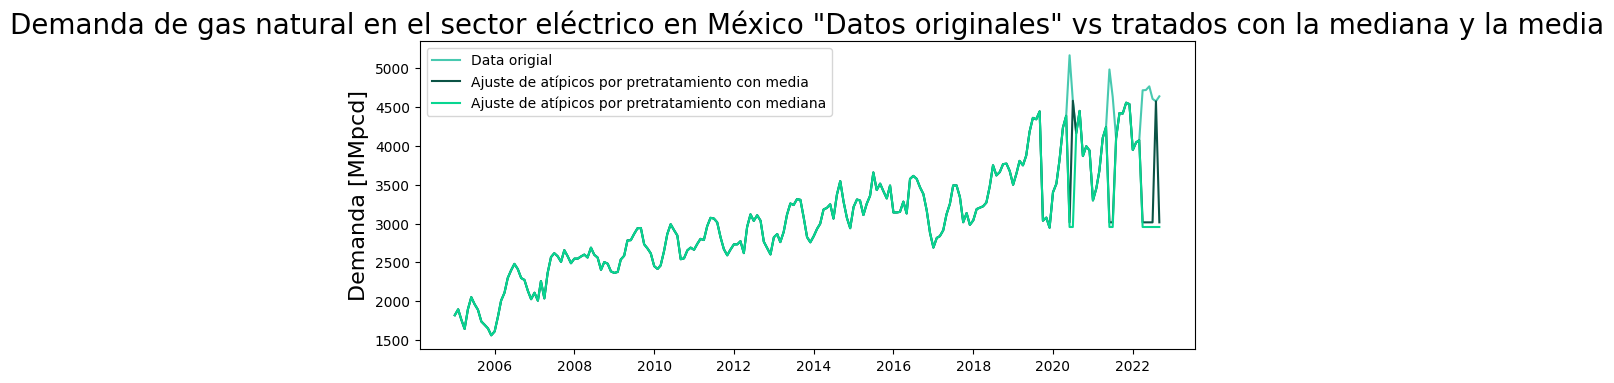

In [144]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.plot(demanda_electrico_train_pretratamiento_mediana, color= '#08D691')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con mediana'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales" vs tratados con la mediana y la media', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

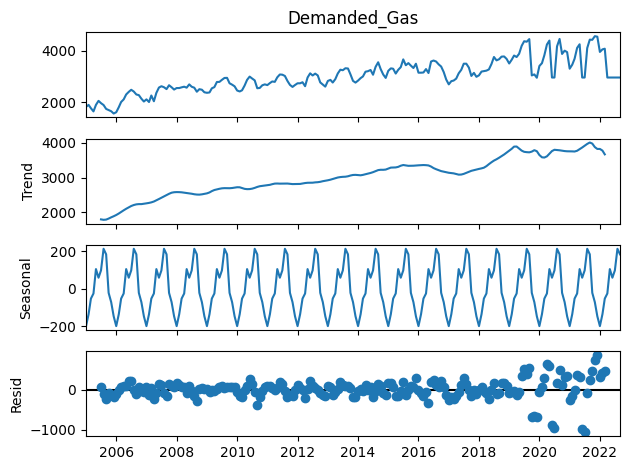

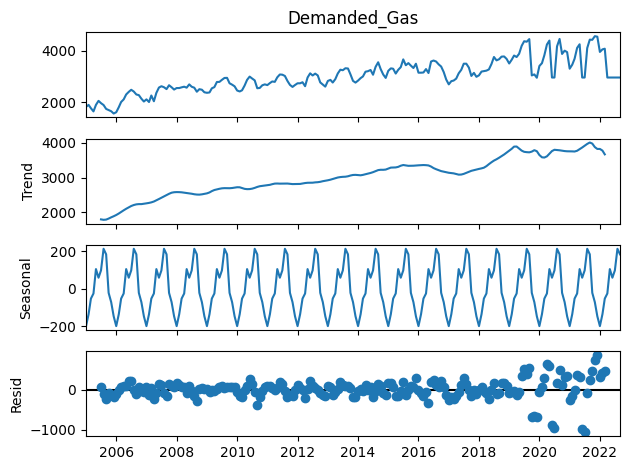

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_electrico_train_pretratamiento_mediana)
demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition.plot()


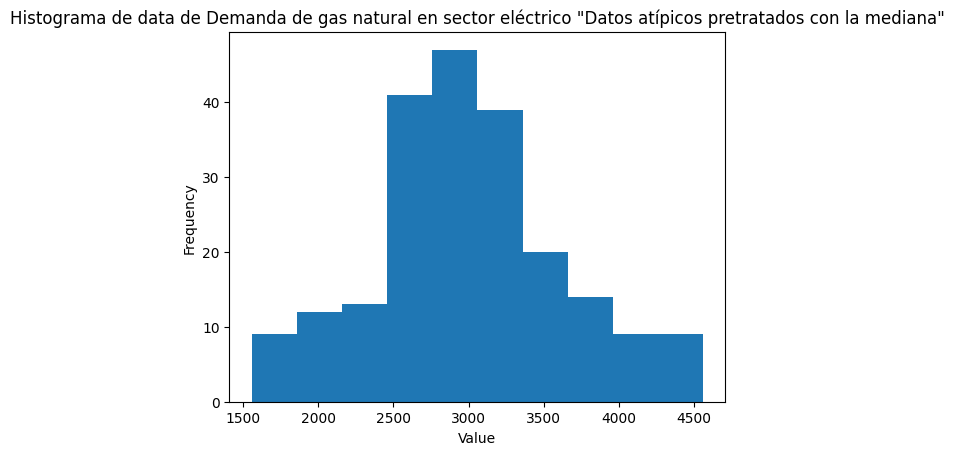

In [146]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

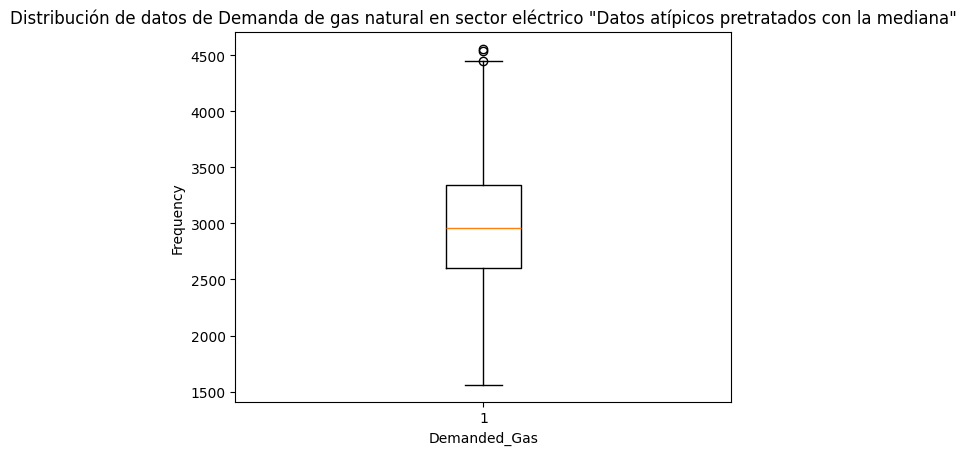

In [147]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_mediana)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [148]:
demanda_electrico_train_pretratamiento_mediana.describe()

count     213.000000
mean     2998.485667
std       634.894699
min      1560.985000
25%      2598.570000
50%      2955.931000
75%      3339.667000
max      4557.360000
Name: Demanded_Gas, dtype: float64

In [149]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 1.8258758281611671
p-value: 0.4013433779096558


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [150]:
n_input = n_input


data = demanda_electrico_train_pretratamiento_mediana
targets = data 

demanda_electrico_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_electrico_train_generator_pretratamiento_mediana[0]

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[1819.585, 1895.325, 1765.856, 1642.696, 1895.54 , 2051.723,
         1962.054, 1889.656, 1739.1  , 1695.917, 1648.948, 1560.985,
         1610.451, 1806.332, 2006.884, 2108.311, 2298.896, 2398.883,
         2480.623, 2413.083, 2298.488, 2273.91 , 2134.41 , 2025.984]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [151]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  213
Total number of samples in the demanda_electrico_scaled_train_generator =  189


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [192]:
seed_value = seed_value

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [193]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_electrico_pretrataminto_mediana = Sequential()

model_LSTM_electrico_pretrataminto_mediana.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretrataminto_mediana.add(Dense(1))
model_LSTM_electrico_pretrataminto_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_electrico_pretrataminto_mediana.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo 

In [194]:
model_LSTM_electrico_pretrataminto_mediana.fit(demanda_electrico_train_generator_pretratamiento_mediana, epochs=15)

Epoch 1/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8391959.0000
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 135125.8906
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 126467.2969
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99310.3125
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 171149.3281
Epoch 6/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 169571.9844
Epoch 7/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 130589.1562
Epoch 8/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142427.7812
Epoch 9/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 114333.6953
Epoch 10/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 110238.4453
Epoch 11/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 157708.4219
Epoch 12/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 144307.2969
Epoch 13/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 134006.5938
Epoch 14/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss:

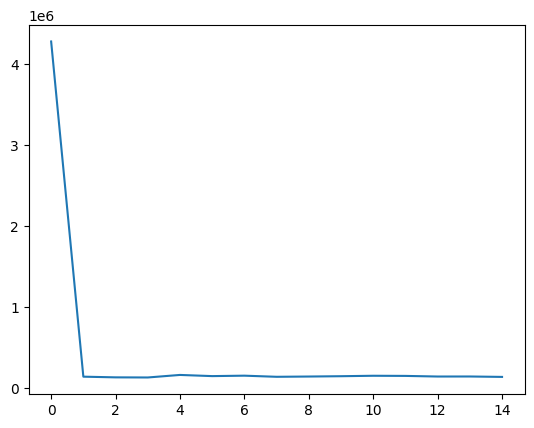

In [195]:
loss_per_epoch = model_LSTM_electrico_pretrataminto_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [196]:
demanda_electrico_train_pretratamiento_mediana

Date
2005-01-01    1819.585
2005-02-01    1895.325
2005-03-01    1765.856
2005-04-01    1642.696
2005-05-01    1895.540
                ...   
2022-05-01    2955.931
2022-06-01    2955.931
2022-07-01    2955.931
2022-08-01    2955.931
2022-09-01    2955.931
Name: Demanded_Gas, Length: 213, dtype: float64

In [156]:
demanda_electrico_train_batch_pretratamiento_mediana = demanda_electrico_train_pretratamiento_mediana[-n_input:]


demanda_electrico_train_batch_pretratamiento_mediana

Date
2020-10-01    3869.766
2020-11-01    3996.138
2020-12-01    3941.119
2021-01-01    3298.428
2021-02-01    3454.211
2021-03-01    3681.295
2021-04-01    4104.817
2021-05-01    4243.934
2021-06-01    2955.931
2021-07-01    2955.931
2021-08-01    4098.808
2021-09-01    4424.394
2021-10-01    4417.514
2021-11-01    4557.360
2021-12-01    4538.887
2022-01-01    3947.786
2022-02-01    4046.826
2022-03-01    4072.984
2022-04-01    2955.931
2022-05-01    2955.931
2022-06-01    2955.931
2022-07-01    2955.931
2022-08-01    2955.931
2022-09-01    2955.931
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [157]:
demanda_electrico_train_batch_pretratamiento_mediana_reshaped = demanda_electrico_train_batch_pretratamiento_mediana.values.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_mediana_reshaped

array([[[3869.766],
        [3996.138],
        [3941.119],
        [3298.428],
        [3454.211],
        [3681.295],
        [4104.817],
        [4243.934],
        [2955.931],
        [2955.931],
        [4098.808],
        [4424.394],
        [4417.514],
        [4557.36 ],
        [4538.887],
        [3947.786],
        [4046.826],
        [4072.984],
        [2955.931],
        [2955.931],
        [2955.931],
        [2955.931],
        [2955.931],
        [2955.931]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [158]:
model_LSTM_electrico_pretrataminto_mediana.predict(demanda_electrico_train_batch_pretratamiento_mediana_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


array([[3377.7092]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [159]:
n_input = n_input
n_features = n_features

In [197]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana  = []

first_eval_batch = demanda_electrico_train_pretratamiento_mediana[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretrataminto_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [198]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana

[array([3713.5657], dtype=float32),
 array([3748.7705], dtype=float32),
 array([3699.302], dtype=float32),
 array([3613.3916], dtype=float32),
 array([3542.0046], dtype=float32),
 array([3475.979], dtype=float32),
 array([3423.1519], dtype=float32),
 array([3339.5781], dtype=float32),
 array([3252.8381], dtype=float32),
 array([3173.8647], dtype=float32),
 array([3209.3958], dtype=float32),
 array([3234.5945], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

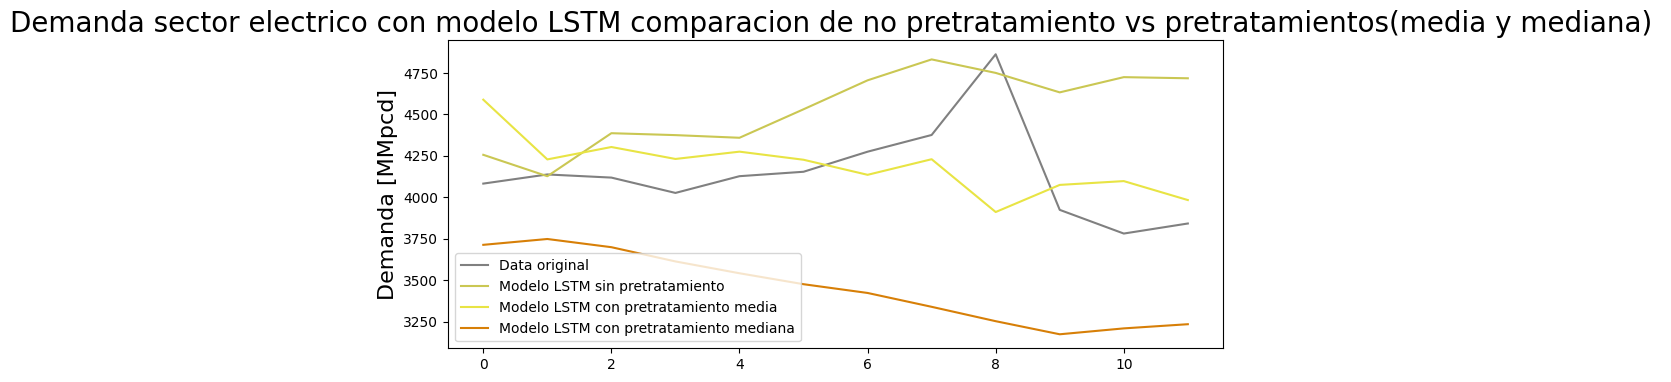

In [199]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07' )
plt.legend(('Data original', 'Modelo LSTM sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector electrico con modelo LSTM comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [200]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)

MAPE: 0.16355072638766488
RMSE: 768.8986721837239


#### Proceso para decidir el modelo ARIMA a aplicar en el caso de (pretratamiento de atípicos por la mediana)

Se verifica la estacionariedad de la data (pretratamiento de atípicos por la mediana) con ayuda de la prueba de Dickey-Fulley

In [164]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_electrico_pretratamiento_mediana_sin_diferenciar = adfuller(demanda_electrico_train_pretratamiento_mediana)

adf_test_electrico_pretratamiento_mediana_sin_diferenciar

(-2.3373037331400126,
 0.16021880072755434,
 11,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 2735.9527113721138)

In [165]:
print(f"The ADF statistic value f is: {adf_test_electrico_pretratamiento_mediana_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_electrico_pretratamiento_mediana_sin_diferenciar[1]}")

if adf_test_electrico_pretratamiento_mediana_sin_diferenciar[0] < adf_test_electrico_pretratamiento_mediana_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -2.3373037331400126
The ADF p value p is: 0.16021880072755434
Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad



Se procede a hacer la primer diferencia para lograr estacionariedad

In [166]:

demanda_electrico_pretratamiento_mediana_diff1 = demanda_electrico_train_pretratamiento_mediana.diff()
demanda_electrico_pretratamiento_mediana_diff1

Date
2005-01-01        NaN
2005-02-01     75.740
2005-03-01   -129.469
2005-04-01   -123.160
2005-05-01    252.844
               ...   
2022-05-01      0.000
2022-06-01      0.000
2022-07-01      0.000
2022-08-01      0.000
2022-09-01      0.000
Name: Demanded_Gas, Length: 213, dtype: float64


Se verifica la estacionariedad de la data DIFERENCIA1 (pretratamiento de atípicos por la mediana) con ayuda de la prueba de Dickey-Fulley

In [167]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_electrico_pretratamiento_mediana_diff1 = adfuller(demanda_electrico_pretratamiento_mediana_diff1.dropna())

adf_test_electrico_pretratamiento_mediana_diff1

(-4.575814971369421,
 0.00014309766936591094,
 15,
 196,
 {'1%': -3.464161278384219,
  '5%': -2.876401960790147,
  '10%': -2.5746921001665974},
 2722.1483149274463)

In [168]:
print(f"The ADF statistic value f is: {adf_test_electrico_pretratamiento_mediana_diff1[0]}")

print(f"The ADF p value p is: {adf_test_electrico_pretratamiento_mediana_diff1[1]}")

if adf_test_electrico_pretratamiento_mediana_diff1[0] < adf_test_electrico_pretratamiento_mediana_diff1[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -4.575814971369421
The ADF p value p is: 0.00014309766936591094
Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad


Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar

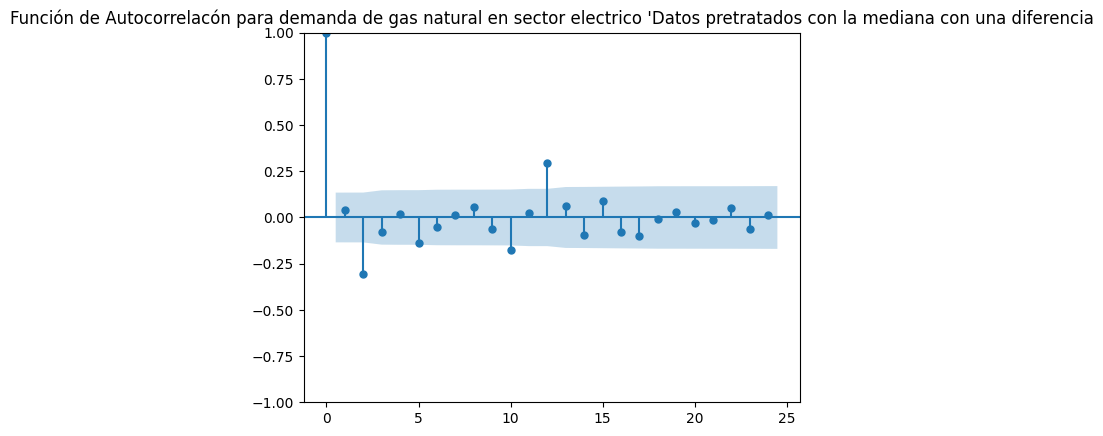

In [169]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_electrico_pretratamiento_mediana_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector electrico 'Datos pretratados con la mediana con una diferencia")

# Show the plot
plt.show()

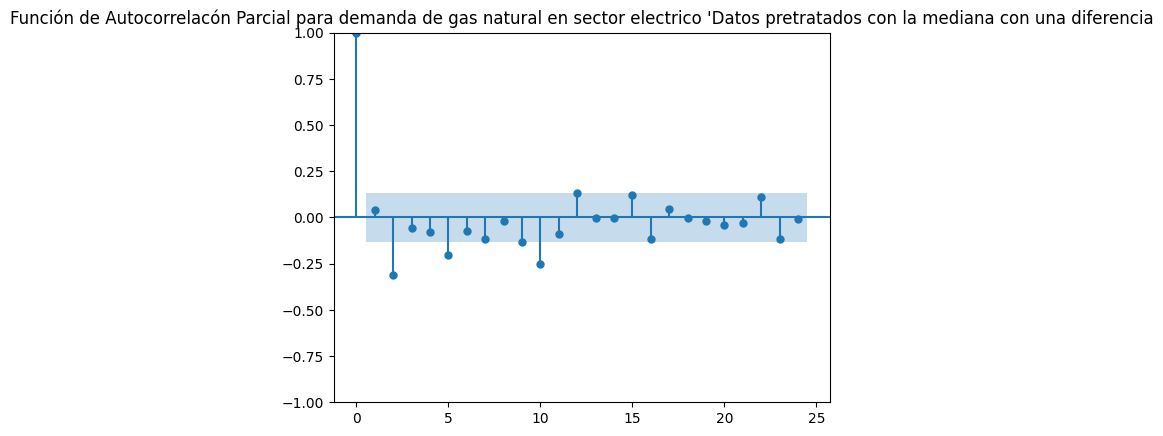

In [170]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_electrico_pretratamiento_mediana_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector electrico 'Datos pretratados con la mediana con una diferencia")

# Show the plot
plt.show()

Modelo ARIMA para el caso del pretratamiento de datos con la mediana 

In [171]:
##Create the model
model_ARIMA_electrico_tratamiento_mediana = ARIMA (demanda_electrico_train_pretratamiento_mediana, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_electrico_tratamiento_mediana_fit = model_ARIMA_electrico_tratamiento_mediana.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_tratamiento_mediana_fit.summary())

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\s

Model fitting time 0.4219508171081543
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1468.379
Date:                Fri, 03 May 2024   AIC                           2950.758
Time:                        11:58:16   BIC                           2974.254
Sample:                    01-01-2005   HQIC                          2960.254
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3195      0.151     -2.113      0.035      -0.616      -0.023
ar.L2         -0.0733      0.119     -0.616      0.538      -0.307       0.160
ar.L3         

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [172]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

In [173]:
##get the predictors and residuals 
predictions_model_ARIMA_electrico_tratamiento_mediana = model_ARIMA_electrico_tratamiento_mediana_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
print(predictions_model_ARIMA_electrico_tratamiento_mediana)

2022-10-01    3032.803003
2022-11-01    3192.833774
2022-12-01    3341.264870
2023-01-01    3310.756580
2023-02-01    3369.245047
2023-03-01    3408.094424
2023-04-01    3380.030788
2023-05-01    3407.939199
2023-06-01    3415.553585
2023-07-01    3400.620447
2023-08-01    3415.230480
2023-09-01    3414.494229
Freq: MS, Name: predicted_mean, dtype: float64


In [174]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_electrico_tratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_mediana)
RMSE_predictions_model_ARIMA_electrico_tratamiento_mediana= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_mediana))

print('MAPE:', MAPE_predictions_model_ARIMA_electrico_tratamiento_mediana)
print('RMSE:', RMSE_predictions_model_ARIMA_electrico_tratamiento_mediana)

MAPE: 0.19049380089832924
RMSE: 850.235647248291


Text(0, 0.5, 'Demanda [MMpcd]')

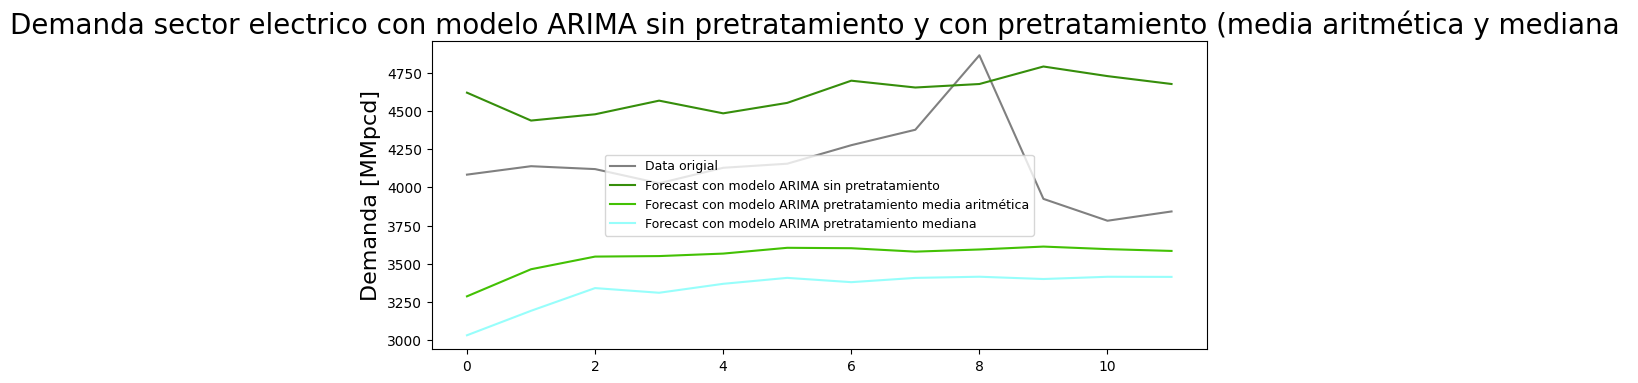

In [175]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')


plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')

plt.plot(predictions_model_ARIMA_electrico_tratamiento_media.values,color='#43C104')
plt.plot(predictions_model_ARIMA_electrico_tratamiento_mediana.values, color='#97FEFB')


plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial','Forecast con modelo ARIMA sin pretratamiento','Forecast con modelo ARIMA pretratamiento media aritmética', 'Forecast con modelo ARIMA pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

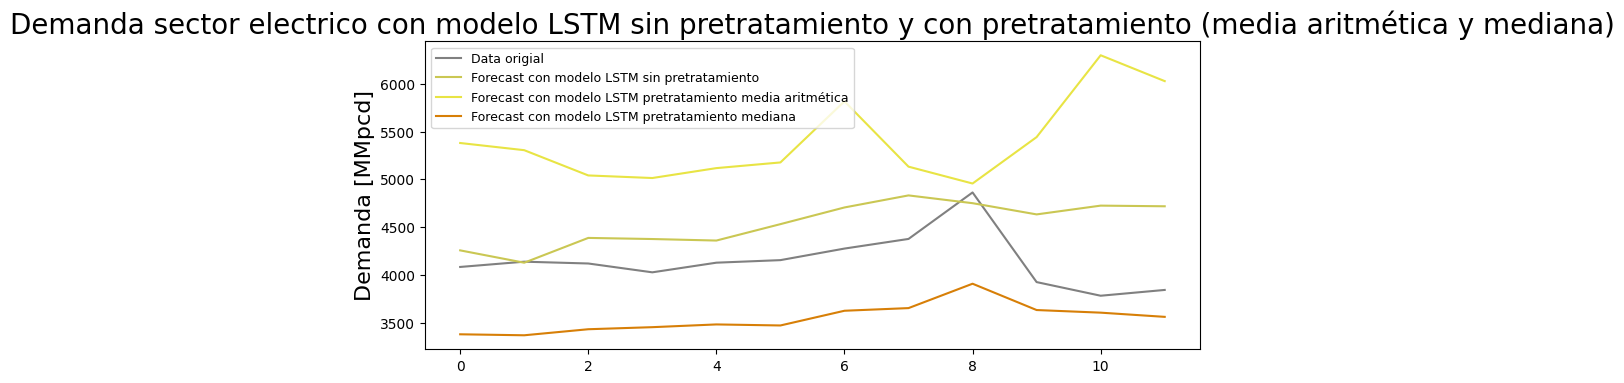

In [176]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')

plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo LSTM pretratamiento media aritmética',  'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media aritmética y mediana)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

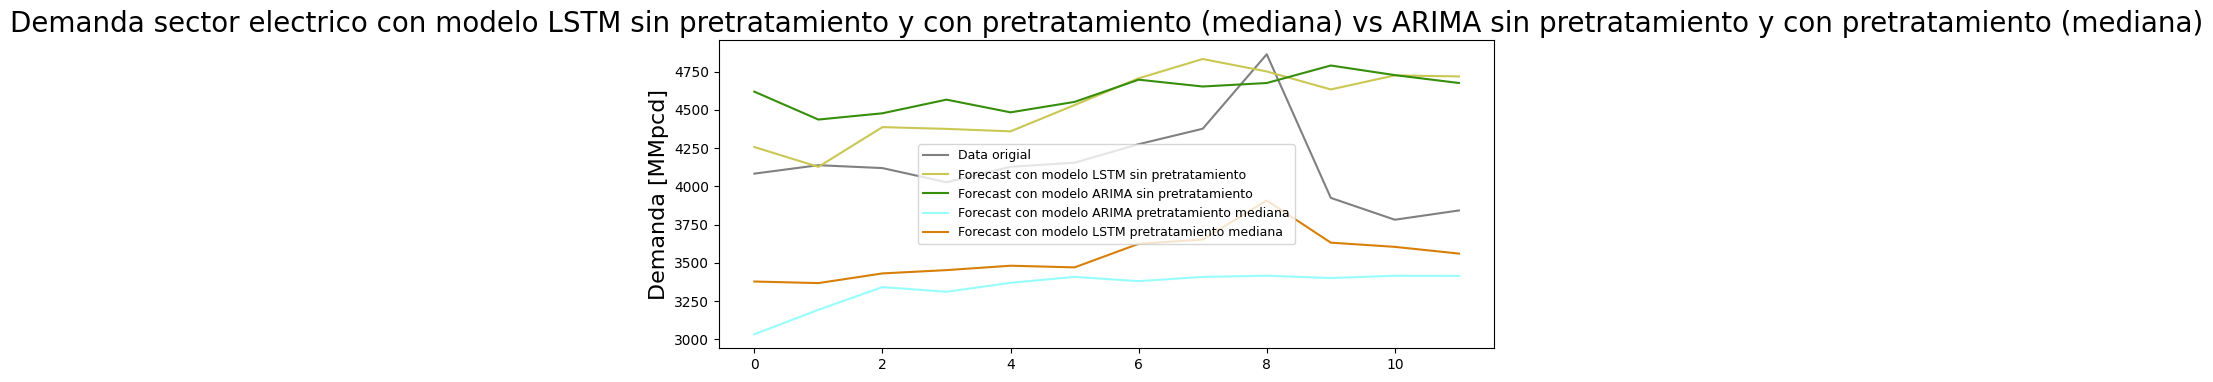

In [177]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')


plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')


plt.plot(predictions_model_ARIMA_electrico_tratamiento_mediana.values, color='#97FEFB')

plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo ARIMA sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento mediana' , 'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (mediana) vs ARIMA sin pretratamiento y con pretratamiento (mediana)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)